## 0. 코드 및 대회 설명
- 이 코드는 데이콘에서 진행한 한국어 문서 추출요약 AI 경진대회(https://dacon.io/competitions/official/235671/overview/) 에서 사용한 코드입니다.
- 본 대회는 주어진 기사 데이터(train.jsonl)의 각 기사마다 중요한 문장을 3개씩 뽑는 대회였으며, 저희 팀은 TextRank, KR-wordrank 패키지, 그리고 자체적으로 피처를 만들어 분류 문제로 바꿔 문제를 해결하였습니다. 이 코드는 분류 문제로 바꿔 문제를 해결한 코드입니다.
- 중앙대학교 2020-2학기 `데이터마이닝(2)` 수업에서 진행한 팀 프로젝트입니다.
- 자세한 코드 설명은 프로젝트 수행 보고서 파일을 참고해주세요.

## 1. 데이터 불러오기 및 데이터 전처리

In [ ]:
#필요한 패키지 로드
import json
import numpy as np
import pandas as pd

import os
import re
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_json('drive/MyDrive/train.jsonl', encoding = 'UTF-8', lines=True)
train.head()

,media,id,article_original,abstractive,extractive
0,당진시대,327827480,[당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,"[0, 1, 2]"
1,국제신문,339840364,[미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,"[0, 1, 3]"
2,기호일보,371071597,"[인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아, 국유지로...",16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,"[6, 7, 10]"
3,대구일보,354806783,[대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,"[1, 6, 4]"
4,대구신문,347022773,[국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,"[2, 3, 10]"


In [ ]:
train.shape

(42803, 5)

### 1) Bias 피처 생성

In [1]:
medialist = list(train['media'].value_counts().index)

biasdat = pd.DataFrame(columns=['bias', 'id2'])

for media in medialist:

    # define dataset
    mediatrain = train.loc[train['media'] == media,]
    mediatrain.reset_index(drop=True, inplace=True) # index 초기화해서 for문 돌게!

    # define bias vector
    fullext = []

    for i, ext in enumerate(mediatrain['extractive']):
        for element in ext:
            fullext.append(element)

    pdfullext = pd.DataFrame({'number' : fullext})
    count = pdfullext['number'].value_counts()
    countdf = count.rename_axis('unique_values').reset_index(name='counts')
    countdf = pd.DataFrame(countdf)
    countdf.sort_values(by = ['unique_values'], axis=0, inplace=True)
    
    mediabiasdat = pd.DataFrame(index=range(0,len(mediatrain)), columns=['bias', 'id2'])
    
    for i in range(len(mediatrain)):
        lenart = len(mediatrain['article_original'][i])

        # 가지고 있는 편향 벡터보다 길면
        if lenart >= len(countdf): 
            # 가지고 있는 편향 벡터만큼 생성
            ogbias = np.array(countdf['counts'][:len(countdf)] / countdf['counts'][len(countdf)-1])
            # 나머지 길이는 전부 다 가중치 1로 동일하게
            others = np.ones(len(mediatrain['article_original'][i]) - len(countdf)) 
            # 두 벡터를 합쳐서 최종 편향 벡터 구성
            biasdf = np.concatenate((ogbias,others)) 
        else :
            biasdf = np.array(countdf['counts'][:lenart] / countdf['counts'][lenart-1])
        
        
        mediabiasdat['id2'][i] = mediatrain['id'][i]
        mediabiasdat['bias'][i] = biasdf
        print('{}th complete!'.format(i))
        
    biasdat = pd.concat([biasdat, mediabiasdat],
                        join='inner',
                       ignore_index=True)

In [ ]:
print(biasdat.shape)
biasdat.head()

(42803, 2)


,bias,id2
0,"[73.03508771929825, 73.0701754385965, 59.92982...",371071597
1,"[5.587919463087248, 5.590604026845638, 4.58523...",359531654
2,"[32.5234375, 32.5390625, 26.6875, 18.3671875, ...",362074213
3,"[19.09633027522936, 19.105504587155963, 15.669...",353044329
4,"[6.9267886855241265, 6.930116472545757, 5.6838...",365168679


In [ ]:
train = pd.merge(train, biasdat, left_on = 'id', right_on='id2')
train.drop(['id2'], axis=1, inplace=True)
train.head()

,media,id,article_original,abstractive,extractive,bias
0,당진시대,327827480,[당진시 문화관광과를 대상으로 하는 행정사무감사에서 당진시립합창단 관계자가 보낸 것...,지난 6일 당진시의회 행정사무감사에서 '합창단이 소리를 작게 낼 것이니 알고 있으라...,"[0, 1, 2]","[6.567741935483871, 8.141935483870968, 6.37419..."
1,국제신문,339840364,[미국 메이저리그(MLB)에서 활동하는 한국 선수들의 시즌 초반 희비가 엇갈리고 있...,LA 에인절스의 최지만이 맹활약을 하여 시즌 타율 0.250에서 0.313으로 올리...,"[0, 1, 3]","[46.44155844155844, 38.61038961038961, 36.5454..."
2,기호일보,371071597,"[인천 부영공원 운영 생활야구협회 80여 동호회 팀에 260만 원씩 받아, 국유지로...",16일 부평구와 협회 등에 따르면 부영공원 안에 있는 야구장을 구생활체육야구협회가 ...,"[6, 7, 10]","[73.03508771929825, 73.0701754385965, 59.92982..."
3,대구일보,354806783,[대구·경북첨단의료산업진흥재단 의약생산센터는 항암주사제 무균충전 시설을 갖추고 있다...,대구·경북첨단의료산업진흥재단 의약생산센터는 약사법 시행규칙에서 정한 바에 따라 전용...,"[1, 6, 4]","[9.920529801324504, 11.178807947019868, 10.788..."
4,대구신문,347022773,[국내 유통되는 탄산음료 중 식품의약품안전처에 품질인증을 받은 제품이 하나도 없는 ...,식품의약품안전처는 29일 어린이가 즐겨마시는 음료를 대상으로 영양성분을 조사한 결과...,"[2, 3, 10]","[25.94047619047619, 26.357142857142858, 23.380..."


### 2) train/validation set split
- 이후에 sentence별로 split을 하면 기사들이 섞이는 문제 -> 미리 나눠놓은 후, train 및 validation set 각각에 대해 전처리 진행 

In [ ]:
#id 기준, train set과 val set은 8:2의 비율로 나눔 
from sklearn.model_selection import train_test_split

X_df = train.drop('id', axis=1)
y_df = train.loc[:,'id']
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.2, random_state=99, shuffle=True)

In [ ]:
print(X_train.shape, X_val.shape)
print(X_train.head())

(34242, 5) (8561, 5)
        media  ...                                               bias
11439    국제신문  ...  [10.642857142857142, 8.848214285714286, 8.375,...
15262    대구신문  ...  [48.422222222222224, 49.2, 43.644444444444446,...
34201    기호일보  ...  [4.457173447537473, 4.4593147751606, 3.6573875...
7198     기호일보  ...  [6.9267886855241265, 6.930116472545757, 5.6838...
26763  광주매일신문  ...  [10.860759493670885, 8.30379746835443, 7.16033...

[5 rows x 5 columns]


In [ ]:
#다시 train, val set으로 묶기
train = X_train.copy()
val = X_val.copy()
train['id'] = y_train
val['id'] = y_val
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
train.head()

,media,article_original,abstractive,extractive,bias,id
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]","[10.642857142857142, 8.848214285714286, 8.375,...",333727228
1,대구신문,[원전해체 산업 육성 추진도 청와대가 16일 기업 활동 지원방안과 관련해 대규모 투...,"정부는 공경경제장관회의에서 소득주도성장 및 혁신성장, 소비자 권익 보호에 관한 논의...","[0, 2, 15]","[48.422222222222224, 49.2, 43.644444444444446,...",331235501
2,기호일보,[오산시는 지난 11일 지역경제 활성화 및 하반기 신속집행 적극적 추진을 위해 20...,오산시는 11일 2019년 하반기 신속집행 부진부서 보고회 자리에서 김문환 부시장...,"[0, 5, 3]","[4.457173447537473, 4.4593147751606, 3.6573875...",366943194
3,기호일보,[이천시가 시민의 적극적이고 능동적인 시정참여를 위한 ‘시민이 주인인 학교’ 1기 ...,이천시가 '시민이 주인인 이천'을 구현하기 위해 올해부터 추진 중인 민주시민교육 '...,"[0, 1, 4]","[6.9267886855241265, 6.930116472545757, 5.6838...",358892168
4,광주매일신문,[전남도는 28일 “축산농가 생산비 절감 및 최적의 사양관리 등 경쟁력 강화를 위해...,28일 전남도는 “축산농가 생산비 절감 및 최적의 사양관리 등 경쟁력 강화를 위해 ...,"[0, 4, 9]","[10.860759493670885, 8.30379746835443, 7.16033...",368911616


In [ ]:
val.head()

,media,article_original,abstractive,extractive,bias,id
0,기호일보,"[포토 : 바세린, [기호일보=디지털뉴스부] 요근래 매일매일 다채로운 Quiz를 내...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]","[6.9267886855241265, 6.930116472545757, 5.6838...",366196093
1,경기일보,"[인천 서구가 미세먼지 줄이기, 보육의 질 향상, 일자리 창출에 나선다., 서구는 ...","인천 서구는 올해 미세먼지 저감대책 마련, 보육의 질 향상, 일자리 창출을 집중적으...","[2, 10, 16]","[73.10526315789474, 70.94736842105263, 54.2631...",333606877
2,대구신문,[경주시는 지난 17일 시청에서 노사발전재단과 지역일자리 컨설팅 지원사업 협약식을 ...,경주시는 17일 노사발전재단과 지역 일자리 모델 개발을 위한 컨설팅과 사업운영을 지...,"[1, 2, 3]","[3.5546492659053834, 3.6117455138662318, 3.203...",345653499
3,국제신문,"[- “김해신공항은 제2의 4대강 사업, - 출향 공무원 부산네트워크 필요”, 오거...",3일 주요 현안에 대한 중앙부처 공무원의 관심과 협조를 당부하고자 정부세종청사에 마...,"[2, 4, 3]","[9.076142131979696, 7.5456852791878175, 7.1421...",340082244
4,당진시대,[▲ 제36회 교정대상에서 공로상을 수상한 이재원 대표(왼)가 박상기 법무부 장관(...,읍내동에서 의류 브랜드 아날도바시니 당진점을 운영하고 있는 이재원 대표가 수용자 교...,"[1, 2, 3]","[30.848484848484848, 38.24242424242424, 29.939...",305296115


In [ ]:
print(train.shape, val.shape)

(34242, 6) (8561, 6)


### 3) 'article_original'의 특수문자 등 제거 

In [ ]:
## pattern들 정의
import re
from string import punctuation

# 한글, 영어, 숫자, 살릴 특수문자들이 아닌 기호들 날리기
patmain = re.compile(r"[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ+@$?\-!<&;()=/_>\"\'*%#`.,:~]")

# white space 2번 이상 반복되면 날리기
patwhite = re.compile(r'\s{2,}') 

In [ ]:
def cleaning(doc):
    return patwhite.sub(' ',
            patmain.sub(' ',doc)).strip()

In [ ]:
#전처리 전 1번 기사 
train['article_original'][0]

['부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울시에 ‘공동 유치’(국제신문 11일 자 1면 보도)를 공식 제안했다.',
 '오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의원 총회의 해당 올림픽 국내 유치 신청 도시 선정 심의를 앞두고 이와 관련한 입장문을 발표했다.',
 '대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 계획을 발표한다.',
 '두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확정된다.',
 '오 시장은 “한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는 중이다.',
 '바야흐로 평화의 시대, 2032년 하계올림픽은 남과 북이 함께 하는 역사적인 ‘평화올림픽’으로 추진돼야 한다”며 “그래서 2032년 하계올림픽의 부산-서울 공동 개최를 제안한다.',
 '북측에서도 평양과 함께 또 다른 도시를 공동개최지로 선정한다면 그야말로 한반도 전체가 하나의 도시로서 평화 올림픽을 치러내는 세계적 평화 이벤트가 될 것”이라고 밝혔다.',
 '그는 “무엇보다 부산의 참여는 2032년 하계올림픽의 한반도 유치에 가장 큰 경쟁력이 될 것”이라며 “바다와 육지, 해양과 대륙이 만나는 부산은 한반도 평화가 시작되는 출발점이자 종착점으로, 이미 북측의 시선은 서울을 넘어 부산에 닿았다”고 부연했다.',
 '그러면서 “역대 올림픽 중 동일한 도시에서 두 번 대회를 유치한 국가는 고작 5곳에 불과하다.',
 '88올림픽을 치러낸 서울에서 단독으로 하계올림픽을 다시 유치하는 것은 그만큼 큰 위험부담이 있는데, 부산과의 공동 유치로 이 문제를 해결할 수 있다”고 말했다.',
 '오 시장은 “부산은 2002년 아시안게임으로 올림픽 종목 경기시설과 운영 노하우를 보유하고 있고, 88올림픽 요트경기를 치렀던 수영만 요트경기장을 비롯해 해양스포츠와 육상 스포츠, 어떤 종목이든 가능한 지리적 장점을 가지고 있다”며 “202

In [ ]:
for i in range(len(train)):
    train['article_original'][i] = list(map(lambda x: cleaning(x), train['article_original'][i]))

In [ ]:
for i in range(len(val)):
    val['article_original'][i] = list(map(lambda x: cleaning(x), val['article_original'][i]))

In [ ]:
#전처리 후 1번 기사
train['article_original'][0]

['부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울시에 공동 유치 (국제신문 11일 자 1면 보도)를 공식 제안했다.',
 '오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의원 총회의 해당 올림픽 국내 유치 신청 도시 선정 심의를 앞두고 이와 관련한 입장문을 발표했다.',
 '대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 계획을 발표한다.',
 '두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확정된다.',
 '오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는 중이다.',
 '바야흐로 평화의 시대, 2032년 하계올림픽은 남과 북이 함께 하는 역사적인 평화올림픽 으로 추진돼야 한다 며 그래서 2032년 하계올림픽의 부산-서울 공동 개최를 제안한다.',
 '북측에서도 평양과 함께 또 다른 도시를 공동개최지로 선정한다면 그야말로 한반도 전체가 하나의 도시로서 평화 올림픽을 치러내는 세계적 평화 이벤트가 될 것 이라고 밝혔다.',
 '그는 무엇보다 부산의 참여는 2032년 하계올림픽의 한반도 유치에 가장 큰 경쟁력이 될 것 이라며 바다와 육지, 해양과 대륙이 만나는 부산은 한반도 평화가 시작되는 출발점이자 종착점으로, 이미 북측의 시선은 서울을 넘어 부산에 닿았다 고 부연했다.',
 '그러면서 역대 올림픽 중 동일한 도시에서 두 번 대회를 유치한 국가는 고작 5곳에 불과하다.',
 '88올림픽을 치러낸 서울에서 단독으로 하계올림픽을 다시 유치하는 것은 그만큼 큰 위험부담이 있는데, 부산과의 공동 유치로 이 문제를 해결할 수 있다 고 말했다.',
 '오 시장은 부산은 2002년 아시안게임으로 올림픽 종목 경기시설과 운영 노하우를 보유하고 있고, 88올림픽 요트경기를 치렀던 수영만 요트경기장을 비롯해 해양스포츠와 육상 스포츠, 어떤 종목이든 가능한 지리적 장점을 가지고 있다 며 2020년 세계탁구선수

In [ ]:
train.head()

,media,article_original,abstractive,extractive,bias,id
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]","[10.642857142857142, 8.848214285714286, 8.375,...",333727228
1,대구신문,[원전해체 산업 육성 추진도 청와대가 16일 기업 활동 지원방안과 관련해 대규모 투...,"정부는 공경경제장관회의에서 소득주도성장 및 혁신성장, 소비자 권익 보호에 관한 논의...","[0, 2, 15]","[48.422222222222224, 49.2, 43.644444444444446,...",331235501
2,기호일보,[오산시는 지난 11일 지역경제 활성화 및 하반기 신속집행 적극적 추진을 위해 20...,오산시는 11일 2019년 하반기 신속집행 부진부서 보고회 자리에서 김문환 부시장...,"[0, 5, 3]","[4.457173447537473, 4.4593147751606, 3.6573875...",366943194
3,기호일보,[이천시가 시민의 적극적이고 능동적인 시정참여를 위한 시민이 주인인 학교 1기 졸업...,이천시가 '시민이 주인인 이천'을 구현하기 위해 올해부터 추진 중인 민주시민교육 '...,"[0, 1, 4]","[6.9267886855241265, 6.930116472545757, 5.6838...",358892168
4,광주매일신문,[전남도는 28일 축산농가 생산비 절감 및 최적의 사양관리 등 경쟁력 강화를 위해 ...,28일 전남도는 “축산농가 생산비 절감 및 최적의 사양관리 등 경쟁력 강화를 위해 ...,"[0, 4, 9]","[10.860759493670885, 8.30379746835443, 7.16033...",368911616


In [ ]:
val.head()

,media,article_original,abstractive,extractive,bias,id
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]","[6.9267886855241265, 6.930116472545757, 5.6838...",366196093
1,경기일보,"[인천 서구가 미세먼지 줄이기, 보육의 질 향상, 일자리 창출에 나선다., 서구는 ...","인천 서구는 올해 미세먼지 저감대책 마련, 보육의 질 향상, 일자리 창출을 집중적으...","[2, 10, 16]","[73.10526315789474, 70.94736842105263, 54.2631...",333606877
2,대구신문,[경주시는 지난 17일 시청에서 노사발전재단과 지역일자리 컨설팅 지원사업 협약식을 ...,경주시는 17일 노사발전재단과 지역 일자리 모델 개발을 위한 컨설팅과 사업운영을 지...,"[1, 2, 3]","[3.5546492659053834, 3.6117455138662318, 3.203...",345653499
3,국제신문,"[- 김해신공항은 제2의 4대강 사업, - 출향 공무원 부산네트워크 필요, 오거돈 ...",3일 주요 현안에 대한 중앙부처 공무원의 관심과 협조를 당부하고자 정부세종청사에 마...,"[2, 4, 3]","[9.076142131979696, 7.5456852791878175, 7.1421...",340082244
4,당진시대,[제36회 교정대상에서 공로상을 수상한 이재원 대표(왼)가 박상기 법무부 장관(가운...,읍내동에서 의류 브랜드 아날도바시니 당진점을 운영하고 있는 이재원 대표가 수용자 교...,"[1, 2, 3]","[30.848484848484848, 38.24242424242424, 29.939...",305296115


### 4)새로운 df에 'article_original'의 문장을 하나씩 빼서 저장 + label 생성 + 'first' 컬럼 +'bias' 컬럼 생성 
- new df는 'article_original', 'article_sent', 'article_token', 'label'이 들어갈 것임 (3번에서 토큰화 진행, 피처구축은 그 이후)
- extractive 값에 포함되는 sentence 번호에 1, 아니면 0 부여
- 뒤에서 이용할 피처 중 하나인 'first'(기사의 첫 번째 문장)이면 1, 아니면 0 부여하는 컬럼 생성

In [ ]:

tmp = []
tmp2 = []

for i in range(len(train)):
    sentences = train['article_original'][i]
    extract = train['extractive'][i]
    biasvec = train['bias'][i]
    
    for j, sent in enumerate(sentences):
        
        if j in train['extractive'][i]:    
            if j==0:
                tmp.append((train.loc[i,'id'], sent, 1, 1))
            else: tmp.append((train.loc[i,'id'], sent, 1, 0))
                
        else: 
            if j==0:
                tmp.append((train.loc[i,'id'], sent, 0, 1))
            else: tmp.append((train.loc[i,'id'], sent, 0, 0))
    
    for bias in biasvec:
        tmp2.append(bias)
     

new_df = pd.DataFrame(tmp, columns=['id','article_sent','label','first'])
new_df

,id,article_sent,label,first
0,333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1
1,333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0
2,333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0
3,333727228,두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확...,1,0
4,333727228,오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는...,0,0
...,...,...,...,...
453898,351719161,2018자카르타-팔렘방 아시안게임에서 여자혼영 200m 금메달을 땄던 김서영은 이번...,0,0
453899,351719161,또 브라질 리우 올림픽에서 다이빙 결선까지 진출하고 2019 FINA 다이빙 그랑프...,0,0
453900,351719161,해외 선수로는 지난 2017년 부다페스트 7관왕인 미국의 카엘렙 드레셀(Caeleb...,0,0
453901,351719161,2016 리우 올림픽과 지난 부다페스트 대회 2관왕인 중국의 수영스타 쑨양(Sun ...,0,0


In [ ]:
new_df2 = pd.DataFrame(tmp2, columns=['bias'])
new_df2

,bias
0,10.642857
1,8.848214
2,8.375000
3,6.511905
4,4.895833
...,...
453898,2.791667
453899,1.541667
453900,1.458333
453901,1.250000


In [ ]:
new_df = pd.concat([new_df, new_df2], axis=1)

In [ ]:
mapperlist = list(range(len(new_df)))
mapperdat = pd.DataFrame(mapperlist, columns=['mapper'])

In [ ]:
new_df = pd.concat([new_df, mapperdat], axis=1, join='inner')
new_train = pd.merge(train, new_df, on='id')
new_train.drop(['bias_x', 'mapper'], axis=1, inplace=True)
new_train.rename(columns={"bias_y": "bias"}, inplace=True)
new_train.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,10.642857
1,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,8.848214
2,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,8.375000
3,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확...,1,0,6.511905
4,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는...,0,0,4.895833


In [ ]:
new_train.shape

(453903, 9)

In [ ]:
new_train[new_train['article_sent'].isna()]

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias


In [ ]:
#validation set에 대해서도 같은 작업을 진행
tmp = []
tmp2 = []

for i in range(len(val)):
    sentences = val['article_original'][i]
    extract = val['extractive'][i]
    biasvec = val['bias'][i]
    
    for j, sent in enumerate(sentences):
        
        if j in val['extractive'][i]:    
            if j==0:
                tmp.append((val.loc[i,'id'], sent, 1, 1))
            else: tmp.append((val.loc[i,'id'], sent, 1, 0))
                
        else: 
            if j==0:
                tmp.append((val.loc[i,'id'], sent, 0, 1))
            else: tmp.append((val.loc[i,'id'], sent, 0, 0))
    
    for bias in biasvec:
        tmp2.append(bias)
     

new_df = pd.DataFrame(tmp, columns=['id','article_sent','label','first'])
new_df

,id,article_sent,label,first
0,366196093,포토 : 바세린,0,1
1,366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0
2,366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0
3,366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0
4,366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0
...,...,...,...,...
113514,341140100,이외에도 빅데이터를 기반으로 실내 미세먼지를 잡는 아트맨 과 전기자동차 충전기 서비...,0,0
113515,341140100,상생혁신포럼은 이번 출범식을 계기로 참여 기업을 확대할 방침이다.,0,0
113516,341140100,스타트업과 지역 기업을 연계해 상생 구조를 만들겠다는 계획이다.,0,0
113517,341140100,실제로 부산경제진흥원의 창업지원사업을 졸업한 프라임오라는 상아제약과 기술개발 공동 ...,0,0


In [ ]:
new_df2 = pd.DataFrame(tmp2, columns=['bias'])
new_df = pd.concat([new_df, new_df2], axis=1)
mapperlist = list(range(len(new_df)))
mapperdat = pd.DataFrame(mapperlist, columns=['mapper'])
new_df = pd.concat([new_df, mapperdat], axis=1, join='inner')
new_val = pd.merge(val, new_df, on='id')
new_val.drop(['bias_x', 'mapper'], axis=1, inplace=True)
new_val.rename(columns={"bias_y": "bias"}, inplace=True)
new_val.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,6.926789
1,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,6.930116
2,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,5.683860
3,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0,3.911814
4,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0,2.923461


In [ ]:
new_val.shape

(113519, 9)

In [ ]:
new_val[new_val['article_sent'].isna()]['label'].value_counts()

Series([], Name: label, dtype: int64)

- 이제 train set: new_train, validation set: new_val 데이터프레임을 계속 사용할 것임!

### 5)토큰화 - Mecab 사용
- new_train df에 새로운 컬럼 'article_token'을 만들고 품사를 태깅한 토큰화 수행

In [ ]:
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
from konlpy.tag import Mecab

In [ ]:
mecab = Mecab()
new_train['article_token'] = new_train['article_sent'].apply(mecab.pos)
new_val['article_token'] = new_val['article_sent'].apply(mecab.pos)
#cf; 품사 태깅을 원한다면 mecab.pos / 명사만 뽑기 mecab.nouns / 형태소만 추출 mecab.morphs
display(new_train.head(3), new_val.head(3))

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,10.642857,"[(부산시, NNP), (가, JKS), (2032, SN), (년, NNBC), ..."
1,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,8.848214,"[(오거돈, NNP), (부산, NNP), (시장, NNG), (은, JX), (1..."
2,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,8.375000,"[(대의원, NNG), (총회, NNG), (심의, NNG), (에, JKB), (..."


,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,6.926789,"[(포토, NNG), (:, SC), (바세린, NNP)]"
1,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,6.930116,"[(기호일보, NNP), (=, SY), (디지털, NNG), (뉴스, NNG), ..."
2,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,5.683860,"[(이, NP), (로, JKB), (인해, VV+EC), (현재, MAG), (대..."


In [ ]:
# 태깅된 품사 중 필요한 태그만 가져오기 - 단, 태그는 더이상 사용하지 않으므로 개별 단어 뒤에 태그는 붙이지 않음. 
significant_tags = ['NNG', 'NNP', 'NNB', 'VV', 'VA', 'VX', 'MAG', 'MAJ', 'XSV', 'XSA']
token_data1 = []
for i in range(len(new_train)):
  tmp=[]
  tokens = new_train.loc[i,'article_token']
  [tmp.append(token[0]) for token in tokens if token[1] in significant_tags]
  token_data1.append(tmp)

In [ ]:
# 태깅된 품사 중 필요한 태그만 가져오기 - 단, 태그는 더이상 사용하지 않으므로 개별 단어 뒤에 태그는 붙이지 않음. 
significant_tags = ['NNG', 'NNP', 'NNB', 'VV', 'VA', 'VX', 'MAG', 'MAJ', 'XSV', 'XSA']
token_data2 = []
for i in range(len(new_val)):
  tmp=[]
  tokens = new_val.loc[i,'article_token']
  [tmp.append(token[0]) for token in tokens if token[1] in significant_tags]
  token_data2.append(tmp)

In [ ]:
new_train['article_token'] = token_data1
new_val['article_token'] = token_data2

## 2. 피처 구축

### 1) SL(Sentence Length)
- 피처명: 'SL'
- 한 문장 내 등장한 단어의 수 / 기사의 가장 긴 문장에서 등장한 단어의 수 

In [ ]:
#저장된 파일을 불러오면 'article_token'이 list인데 str으로 인식되는 문제 해결 
#new_train['article_token'] = new_train['article_token'].apply(eval)

In [ ]:
#각 문장의 token 개수 반환 -> 'SL1'
sl_full1 = []
for i in range(len(new_train)):
  sl1 = len(new_train['article_token'][i])
  sl_full1.append(sl1)

new_train['SL1'] = sl_full1

In [ ]:
#각 article 내 가장 긴 문장의 token 개수 반환-> 'SL2'
sl_full2 = pd.DataFrame(new_train.groupby(by='id')['SL1'].max())
sl_full2.reset_index(inplace=True)
sl_full2.head()

,id,SL1
0,250362727,34
1,250366714,28
2,250366726,59
3,250366727,22
4,250371207,24


In [ ]:
sl_full2.rename(columns={'SL1':'SL2'}, inplace=True)
new_train = pd.merge(new_train, sl_full2, on='id')

In [ ]:
#문장의 길이의 비 ('SL' 컬럼) 계산
new_train['SL'] = new_train['SL1']/new_train['SL2']
new_train.drop(labels=['SL1','SL2'], axis=1, inplace=True) #필요 없는 컬럼 삭제
new_train.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,10.642857,"[부산시, 하계, 올림픽, 국내, 유치, 신청, 도시, 선정, 앞두, 경쟁, 도시,...",0.466667
1,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,8.848214,"[오거돈, 부산, 시장, 오후, 충북, 진천, 국가, 대표, 선수, 촌, 대한체육회...",0.577778
2,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,8.375000,"[대의원, 총회, 심의, 오거돈, 부산, 시장, 박원순, 서울, 시장, 참석, 각각...",0.333333
3,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확...,1,0,6.511905,"[광역, 단체장, 발표, 질, 응답, 뒤, 대의원, 투표, 국내, 유치, 도시, 확정]",0.266667
4,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는...,0,0,4.895833,"[시장, 한반도, 수, 없, 평화, 미래, 또, 걸음, 내딛, 중]",0.222222


In [ ]:
# val set에 대해서도 같은 과정 진행
#각 문장의 token 개수 반환 -> 'SL1'
sl_full1 = []
for i in range(len(new_val)):
  sl1 = len(new_val['article_token'][i])
  sl_full1.append(sl1)

new_val['SL1'] = sl_full1

#각 article 내 가장 긴 문장의 token 개수 반환-> 'SL2'
sl_full2 = pd.DataFrame(new_val.groupby(by='id')['SL1'].max())
sl_full2.reset_index(inplace=True)
sl_full2.rename(columns={'SL1':'SL2'}, inplace=True)
new_val = pd.merge(new_val, sl_full2, on='id')

#문장의 길이의 비 ('SL' 컬럼) 계산
new_val['SL'] = new_val['SL1']/new_val['SL2']
new_val.drop(labels=['SL1','SL2'], axis=1, inplace=True) #필요 없는 컬럼 삭제
new_val.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,6.926789,"[포토, 바세린]",0.054054
1,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,6.930116,"[기호일보, 디지털, 뉴스, 부, 근래, 매일, 매일, 내놓, 있, 이번, 바세린,...",0.405405
2,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,5.683860,"[현재, 대형, 포털, 서, 칭, 리스트, 상단, 바세린, 입술, 순위, 장악, 하...",0.540541
3,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0,3.911814,"[바세린, 입술, 과, 관련, 내용, 열거, 후, 내용, 들어가, 단어, 묻]",0.297297
4,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0,2.923461,"[이어, 복사, 해당, 문구, 넣, 후, 엔터, 나오, 결과물, 참조, 하, 설명,...",0.648649


### 2) TF-ISF 값 
- 우리가 구하려고 하는 TF-ISF는 TF(term frequency) * ISF(inverse Sentence frequency)임.
- TF-IDF에서 D(document)를 S(sentence)로 바꾼 개념이라고 생각.
- tf(s,t): 특정 "문장" s에서의 특정 단어 t의 등장 횟수 
- isf(t): 특정 단어 t가 등장한 "문장"의 수의 역수
- 참고) TF-IDF는 모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단하며, 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단합니다. TF-IDF 값이 낮으면 중요도가 낮은 것이며, TF-IDF 값이 크면 중요도가 큰 것입니다. 즉, the나 a와 같이 불용어의 경우에는 모든 문서에 자주 등장하기 마련이기 때문에 자연스럽게 불용어의 TF-IDF의 값은 다른 단어의 TF-IDF에 비해서 낮아지게 됩니다. (문서를 '문장'으로 바꿔서 읽으면 됨)

In [ ]:
def tf(t, d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc
    return log(N/(df + 1)) +1

def tfidf(t, d):
    return tf(t,d)* idf(t)

In [ ]:
import pandas as pd # 데이터프레임 사용을 위해
from math import log # IDF 계산을 위해

mecab = Mecab()

In [ ]:
#유니크한 id 리스트 만들기
id_list = new_train['id'].unique()
su_list =[]
error_list=[]
#각 id가 들어있는 미니 df 만듦
for id in id_list:
  # try:
    tmp = new_train[new_train['id']==id]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수
  
    ## TF-IDF 행렬
    result = []
    for i in range(N):
      result.append([])
      d = docs[i] #sent
      for j in range(len(vocab)):
        t = vocab[j] #word 
        result[-1].append(tfidf(t,d))
    
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tf_list = tfidf_.mean(axis=1).tolist()
    su_list.extend(tf_list)
  # except:
  #   error_list.append(id)

In [ ]:
len(su_list)

453903

In [ ]:
new_train['TF_ISF'] = su_list
new_train.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,10.642857,"[부산시, 하계, 올림픽, 국내, 유치, 신청, 도시, 선정, 앞두, 경쟁, 도시,...",0.466667,0.421750
1,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,8.848214,"[오거돈, 부산, 시장, 오후, 충북, 진천, 국가, 대표, 선수, 촌, 대한체육회...",0.577778,0.550548
2,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,8.375000,"[대의원, 총회, 심의, 오거돈, 부산, 시장, 박원순, 서울, 시장, 참석, 각각...",0.333333,0.244185
3,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확...,1,0,6.511905,"[광역, 단체장, 발표, 질, 응답, 뒤, 대의원, 투표, 국내, 유치, 도시, 확정]",0.266667,0.229979
4,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는...,0,0,4.895833,"[시장, 한반도, 수, 없, 평화, 미래, 또, 걸음, 내딛, 중]",0.222222,0.157651


In [ ]:
new_train['TF_ISF'].isna().sum()

0

In [ ]:
# for validation

id_list = new_val['id'].unique()
su_list =[]
error_list=[]
#각 id가 들어있는 미니 df 만듦
for id in id_list:
  # try:
    tmp = new_val[new_val['id']==id]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수
  
    ## TF-IDF 행렬
    result = []
    for i in range(N):
      result.append([])
      d = docs[i] #sent
      for j in range(len(vocab)):
        t = vocab[j] #word 
        result[-1].append(tfidf(t,d))
    
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tf_list = tfidf_.mean(axis=1).tolist()
    su_list.extend(tf_list)
  # except:
  #   error_list.append(id)

In [ ]:
new_val['TF_ISF'] = su_list
print(new_val['TF_ISF'].isna().sum())
new_val.head()

0


,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,6.926789,"[포토, 바세린]",0.054054,0.057993
1,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,6.930116,"[기호일보, 디지털, 뉴스, 부, 근래, 매일, 매일, 내놓, 있, 이번, 바세린,...",0.405405,0.322731
2,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,5.683860,"[현재, 대형, 포털, 서, 칭, 리스트, 상단, 바세린, 입술, 순위, 장악, 하...",0.540541,0.453334
3,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0,3.911814,"[바세린, 입술, 과, 관련, 내용, 열거, 후, 내용, 들어가, 단어, 묻]",0.297297,0.299018
4,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0,2.923461,"[이어, 복사, 해당, 문구, 넣, 후, 엔터, 나오, 결과물, 참조, 하, 설명,...",0.648649,0.585356


### 3) sent2sim: 각 문장 간 유사도 구하기 

In [ ]:
def cos_like(array1, array2):
        num = float(np.matmul(array1, array2))
        s = np.linalg.norm(array1) * np.linalg.norm(array2)
        if s ==0:
            result = 0.0
        else:
            result = num/s
        return result

In [ ]:
#유니크한 id 리스트 만들기
id_list = new_train['id'].unique()
su_list2 =[]

#각 id가 들어있는 미니 df 만듦
for id in id_list:
    tmp = new_train[new_train['id']==id]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수
  
    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))
    
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #각 문장의 유사도 합 
    sim_list = []
    for i in range(len(tfarr)):
        txt =[]
        for j in range(1, len(tfarr)):
            c= cos_like(tfarr[i], tfarr[j])
            txt.append(c)
            sim_sum = sum(txt)
        sim_list.append(sim_sum)
    su_list2.extend(sim_list)


In [ ]:
len(su_list2)

453903

In [ ]:
new_train['sent2sim'] = su_list2
new_train.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF,sent2sim
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,10.642857,"[부산시, 하계, 올림픽, 국내, 유치, 신청, 도시, 선정, 앞두, 경쟁, 도시,...",0.466667,0.421750,1.643160
1,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,8.848214,"[오거돈, 부산, 시장, 오후, 충북, 진천, 국가, 대표, 선수, 촌, 대한체육회...",0.577778,0.550548,2.468398
2,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,8.375000,"[대의원, 총회, 심의, 오거돈, 부산, 시장, 박원순, 서울, 시장, 참석, 각각...",0.333333,0.244185,2.285997
3,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확...,1,0,6.511905,"[광역, 단체장, 발표, 질, 응답, 뒤, 대의원, 투표, 국내, 유치, 도시, 확정]",0.266667,0.229979,1.524343
4,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는...,0,0,4.895833,"[시장, 한반도, 수, 없, 평화, 미래, 또, 걸음, 내딛, 중]",0.222222,0.157651,2.248480


In [ ]:
new_train[new_train['sent2sim'].isna()]

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF,sent2sim


In [ ]:
# for validation
#유니크한 id 리스트 만들기
id_list = new_val['id'].unique()
su_list3 =[]

#각 id가 들어있는 미니 df 만듦
for id in id_list:
    tmp = new_val[new_val['id']==id]
    doc_list = tmp['article_sent'].tolist()
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수
  
    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))
    
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #각 문장의 유사도 합 
    sim_list = []
    for i in range(len(tfarr)):
        txt =[]
        for j in range(1, len(tfarr)):
            c= cos_like(tfarr[i], tfarr[j])
            txt.append(c)
            sim_sum = sum(txt)
        sim_list.append(sim_sum)
    su_list3.extend(sim_list)


In [ ]:
new_val['sent2sim'] = su_list3
new_val.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF,sent2sim
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,6.926789,"[포토, 바세린]",0.054054,0.057993,1.509345
1,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,6.930116,"[기호일보, 디지털, 뉴스, 부, 근래, 매일, 매일, 내놓, 있, 이번, 바세린,...",0.405405,0.322731,1.800734
2,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,5.683860,"[현재, 대형, 포털, 서, 칭, 리스트, 상단, 바세린, 입술, 순위, 장악, 하...",0.540541,0.453334,1.607474
3,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0,3.911814,"[바세린, 입술, 과, 관련, 내용, 열거, 후, 내용, 들어가, 단어, 묻]",0.297297,0.299018,1.729383
4,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0,2.923461,"[이어, 복사, 해당, 문구, 넣, 후, 엔터, 나오, 결과물, 참조, 하, 설명,...",0.648649,0.585356,1.593133


In [ ]:
new_val['sent2sim'].isna().sum()

0

### 4) ab2sim: abstractive와 해당 문장 간 유사도 구하기

In [ ]:
#유니크한 id 리스트 만들기
id_list = new_train['id'].unique()
ab_list =[]

#각 id가 들어있는 미니 df 만듦
for id in id_list:
    tmp = new_train[new_train['id']==id]
    doc_a = tmp['abstractive'].tolist()[0]
    doc_list = tmp['article_sent'].tolist()
    doc_list.append(doc_a)
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수
  
    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))
    
    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #마지막 문장(요약문)과 다른 문장 간  유사도
    txt =[]
    for i in range(len(tfarr)-1):
      c= cos_like(tfarr[-1], tfarr[i])
      txt.append(c)

    ab_list.extend(txt)

In [ ]:
len(ab_list)

453903

In [ ]:
new_train['ab2sim'] = ab_list
new_train.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF,sent2sim,ab2sim
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,10.642857,"[부산시, 하계, 올림픽, 국내, 유치, 신청, 도시, 선정, 앞두, 경쟁, 도시,...",0.466667,0.421750,1.643160,0.544845
1,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,8.848214,"[오거돈, 부산, 시장, 오후, 충북, 진천, 국가, 대표, 선수, 촌, 대한체육회...",0.577778,0.550548,2.468398,0.298872
2,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,8.375000,"[대의원, 총회, 심의, 오거돈, 부산, 시장, 박원순, 서울, 시장, 참석, 각각...",0.333333,0.244185,2.285997,0.193521
3,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확...,1,0,6.511905,"[광역, 단체장, 발표, 질, 응답, 뒤, 대의원, 투표, 국내, 유치, 도시, 확정]",0.266667,0.229979,1.524343,0.648721
4,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는...,0,0,4.895833,"[시장, 한반도, 수, 없, 평화, 미래, 또, 걸음, 내딛, 중]",0.222222,0.157651,2.248480,0.034450


In [ ]:
new_train['ab2sim'].isna().sum()

0

In [ ]:
#val set에 대해서도 같은 과정 진행
id_list = new_val['id'].unique()
ab_list =[]

#각 id가 들어있는 미니 df 만듦
for id in id_list:
    tmp = new_val[new_val['id']==id]
    doc_a = tmp['abstractive'].tolist()[0]
    doc_list = tmp['article_sent'].tolist()
    doc_list.append(doc_a)
    docs = [' '.join(mecab.nouns(doc)) for doc in doc_list] #앞의 doc_list의 문장들을 명사만 남긴 문장으로 변환 
    vocab = list(set(w for doc in docs for w in doc.split())) #word

    N = len(docs) # 총 문서의 수

    ## TF-IDF 행렬
    result = []
    for i in range(N):
        result.append([])
        d = docs[i] #sent
        for j in range(len(vocab)):
            t = vocab[j] #word 
            result[-1].append(tfidf(t,d))

    tfidf_ = pd.DataFrame(result, columns = vocab) #행렬
    tfarr = tfidf_.values #array로 변환 

    #마지막 문장(요약문)과 다른 문장 간  유사도
    txt =[]
    for i in range(len(tfarr)-1):
        c= cos_like(tfarr[-1], tfarr[i])
        txt.append(c)

    ab_list.extend(txt)

In [ ]:
new_val['ab2sim'] =ab_list
print(new_val['ab2sim'].isna().sum())
new_val.head()

0


,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF,sent2sim,ab2sim
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,6.926789,"[포토, 바세린]",0.054054,0.057993,1.509345,0.146774
1,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,6.930116,"[기호일보, 디지털, 뉴스, 부, 근래, 매일, 매일, 내놓, 있, 이번, 바세린,...",0.405405,0.322731,1.800734,0.160651
2,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,5.683860,"[현재, 대형, 포털, 서, 칭, 리스트, 상단, 바세린, 입술, 순위, 장악, 하...",0.540541,0.453334,1.607474,0.081672
3,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0,3.911814,"[바세린, 입술, 과, 관련, 내용, 열거, 후, 내용, 들어가, 단어, 묻]",0.297297,0.299018,1.729383,0.752785
4,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0,2.923461,"[이어, 복사, 해당, 문구, 넣, 후, 엔터, 나오, 결과물, 참조, 하, 설명,...",0.648649,0.585356,1.593133,0.079717


### 5) SP(Sentence Position) 
- 문장의 몇 번 위치인지에 따라 percentile 값 도출

In [ ]:
perclist = []
for i in range(len(new_train)):
    length = len(new_train['article_original'][i])
    for num in range(length):
        perc = num / length
        perclist.append(round(perc, 5))

len(perclist)

7234211

In [ ]:
percvec = pd.DataFrame(perclist, columns=['SP'])
new_train['SP'] = percvec
new_train.head(3)

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF,sent2sim,ab2sim,SP
0,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,10.642857,"[부산시, 하계, 올림픽, 국내, 유치, 신청, 도시, 선정, 앞두, 경쟁, 도시,...",0.466667,0.421750,1.643160,0.544845,0.00000
1,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,8.848214,"[오거돈, 부산, 시장, 오후, 충북, 진천, 국가, 대표, 선수, 촌, 대한체육회...",0.577778,0.550548,2.468398,0.298872,0.07692
2,국제신문,[부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서...,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,8.375000,"[대의원, 총회, 심의, 오거돈, 부산, 시장, 박원순, 서울, 시장, 참석, 각각...",0.333333,0.244185,2.285997,0.193521,0.15385


In [ ]:
#val set에 대해서도 같은 과정 진행
perclist = []
for i in range(len(new_val)):
    length = len(new_val['article_original'][i])
    for num in range(length):
        perc = num / length
        perclist.append(round(perc, 5))

In [ ]:
percvec = pd.DataFrame(perclist, columns=['SP'])
new_val['SP'] = percvec
new_val.head()

,media,article_original,abstractive,extractive,id,article_sent,label,first,bias,article_token,SL,TF_ISF,sent2sim,ab2sim,SP
0,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,6.926789,"[포토, 바세린]",0.054054,0.057993,1.509345,0.146774,0.00000
1,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,6.930116,"[기호일보, 디지털, 뉴스, 부, 근래, 매일, 매일, 내놓, 있, 이번, 바세린,...",0.405405,0.322731,1.800734,0.160651,0.11111
2,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,5.683860,"[현재, 대형, 포털, 서, 칭, 리스트, 상단, 바세린, 입술, 순위, 장악, 하...",0.540541,0.453334,1.607474,0.081672,0.22222
3,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0,3.911814,"[바세린, 입술, 과, 관련, 내용, 열거, 후, 내용, 들어가, 단어, 묻]",0.297297,0.299018,1.729383,0.752785,0.33333
4,기호일보,"[포토 : 바세린, 기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고...",매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0,2.923461,"[이어, 복사, 해당, 문구, 넣, 후, 엔터, 나오, 결과물, 참조, 하, 설명,...",0.648649,0.585356,1.593133,0.079717,0.44444


### 6)bias 
- media별 bias 값을 구한 피처
- 전처리 과정에서 생성완료함

### 7) first
- 첫번쨰 문장이면 1, 아니면 0
- 전처리 과정에서 생성완료함

In [ ]:
# csv 파일로 저장
new_train2= new_train.drop('article_original', axis=1)
new_train2.to_csv('new_train2.csv', index=False)
new_val.to_csv('new_val.csv', index=False)
from google.colab import files
files.download('new_train2.csv')
files.download('new_val.csv')

## 3. modeling for classification
- 만들어진 new_train dataframe을 이용해 모델을 만듦 
- 하이퍼 파라미터 튜닝) train set 이용
- 그 이후 new_val로 성능 평가 - 기준은 accuracy

In [ ]:
new_train = pd.read_csv('drive/MyDrive/concattrain.csv')
new_val = pd.read_csv('drive/MyDrive/concatval.csv')
display(new_train.head(), new_val.head())

,media,abstractive,extractive,id,article_sent,label,first,article_token,SL,TF_ISF,sent2sim,ab2sim,SP,bias
0,국제신문,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,1,1,"['부산시', '하계', '올림픽', '국내', '유치', '신청', '도시', '...",0.466667,0.421750,1.643160,0.544845,0.00000,10.402214
1,국제신문,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오거돈 부산시장은 11일 오후 충북 진천 국가대표 선수촌에서 열릴 대한체육회의 대의...,0,0,"['오거돈', '부산', '시장', '오후', '충북', '진천', '국가', '대...",0.577778,0.550548,2.468398,0.298872,0.07692,8.749077
2,국제신문,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,대의원 총회 심의에는 오거돈 부산시장과 박원순 서울시장이 참석해 각각 올림픽 유치 ...,0,0,"['대의원', '총회', '심의', '오거돈', '부산', '시장', '박원순', ...",0.333333,0.244185,2.285997,0.193521,0.15385,8.206642
3,국제신문,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,두 광역단체장의 발표와 질의응답을 거친 뒤 대의원 투표를 통해 국내 유치 도시가 확...,1,0,"['광역', '단체장', '발표', '질', '응답', '뒤', '대의원', '투표...",0.266667,0.229979,1.524343,0.648721,0.23077,6.439114
4,국제신문,부산시가 2032년 하계올림픽 국내 유치 신청 도시 선정을 앞두고 경쟁 도시인 서울...,"[0, 5, 3]",333727228,오 시장은 한반도는 되돌릴 수 없는 평화의 미래를 향해 또 한 번 큰 걸음을 내딛는...,0,0,"['시장', '한반도', '수', '없', '평화', '미래', '또', '걸음',...",0.222222,0.157651,2.248480,0.034450,0.30769,4.808118


,media,abstractive,extractive,id,article_sent,label,first,article_token,SL,TF_ISF,sent2sim,ab2sim,SP,bias
0,기호일보,매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,포토 : 바세린,0,1,"['포토', '바세린']",0.054054,0.057993,1.509345,0.146774,0.00000,7.025862
1,기호일보,매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,기호일보=디지털뉴스부 요근래 매일매일 다채로운 Quiz를 내놓고 있는 TOSS'가 ...,1,0,"['기호일보', '디지털', '뉴스', '부', '근래', '매일', '매일', '...",0.405405,0.322731,1.800734,0.160651,0.11111,6.922414
2,기호일보,매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이로인해 현재 대형포털의 서칭리스트 상단에 바세린 바른입술 이 순위권을 장악하고 있...,0,0,"['현재', '대형', '포털', '서', '칭', '리스트', '상단', '바세린...",0.540541,0.453334,1.607474,0.081672,0.22222,5.689655
3,기호일보,매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,칠 일 'toss'에는 바세린 바른입술 과 관련한 event에 대한 내용을 열거한 ...,1,0,"['바세린', '입술', '과', '관련', '내용', '열거', '후', '내용'...",0.297297,0.299018,1.729383,0.752785,0.33333,3.767241
4,기호일보,매일 다채로운 Quiz 를 내놓고 있는 'TOSS'가 '바세린 바른 입술'과 관련한...,"[1, 3, 5]",366196093,이어 hint로 naver에서 복사한 해당 문구를 붙여넣기를 한 후 엔터를 쳐 나오...,0,0,"['이어', '복사', '해당', '문구', '넣', '후', '엔터', '나오',...",0.648649,0.585356,1.593133,0.079717,0.44444,2.879310


In [ ]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453837 entries, 0 to 453836
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   media          453837 non-null  object 
 1   abstractive    453837 non-null  object 
 2   extractive     453837 non-null  object 
 3   id             453837 non-null  int64  
 4   article_sent   453837 non-null  object 
 5   label          453837 non-null  int64  
 6   first          453837 non-null  int64  
 7   article_token  453837 non-null  object 
 8   SL             453837 non-null  float64
 9   TF_ISF         453837 non-null  float64
 10  sent2sim       453837 non-null  float64
 11  ab2sim         453837 non-null  float64
 12  SP             453837 non-null  float64
 13  bias           453837 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 48.5+ MB


In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#또 어떤 모델을 넣을까

from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


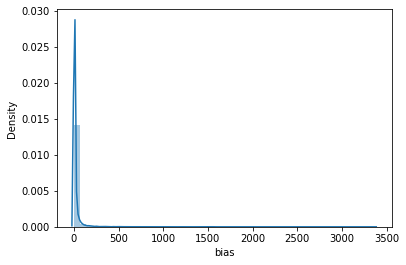

In [ ]:
#bias 분포 확인
sns.distplot(new_train['bias'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


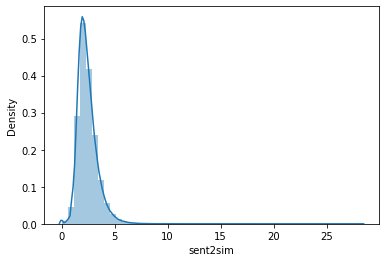

In [ ]:
#sent2sim 분포 확인
sns.distplot(new_train['sent2sim'])
plt.show()
## 가우시안 분포를 따른다면 표준화, 아니면 정규화 진행 

In [ ]:
#X, y 나누기(위에서부터 실행시 'article_original' 컬럼도 drop!!)
train_x = new_train.drop(['abstractive','extractive','id','article_sent','label','article_token'], axis=1) #필요한 피처 제외 모두 drop
train_y = new_train.loc[:, 'label']
val_x = new_val.drop(['abstractive','extractive','article_sent','label','article_token'], axis=1) #val에는 id 남기고 돌리기(나중에 id별로 잘 뽑혔는지 보기위해)
val_y = new_val.loc[:, 'label']

In [ ]:
train_x.drop(['media'], axis=1, inplace=True)
val_x.drop(['media'], axis=1, inplace=True)

In [ ]:
train_x.shape, val_x.shape

((453837, 7), (113515, 8))

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import make_column_transformer
transformer = make_column_transformer(
    (PowerTransformer(), ['bias', 'sent2sim']),
    remainder='drop')

In [ ]:
transformer.fit(train_x)
transformedcol = transformer.transform(train_x)
transformedcol = pd.DataFrame(transformedcol)

In [ ]:
train_x['transformed_bias'] = transformedcol[0]
train_x['transformed_sent2sim'] = transformedcol[1]
train_x.drop(['sent2sim','bias'], axis=1, inplace=True)
train_x.head()

,first,SL,TF_ISF,ab2sim,SP,transformed_bias,transformed_sent2sim
0,1,0.466667,0.421750,0.544845,0.00000,0.670039,-0.872133
1,0,0.577778,0.550548,0.298872,0.07692,0.538631,0.192674
2,0,0.333333,0.244185,0.193521,0.15385,0.488308,-0.016781
3,0,0.266667,0.229979,0.648721,0.23077,0.289419,-1.055196
4,0,0.222222,0.157651,0.034450,0.30769,0.033960,-0.061445


In [ ]:
transformer.fit(val_x)
transformedcol = transformer.transform(val_x)
transformedcol = pd.DataFrame(transformedcol)

In [ ]:
val_x['transformed_bias'] = transformedcol[0]
val_x['transformed_sent2sim'] = transformedcol[1]
val_x.drop(['sent2sim','bias'], axis=1, inplace=True)

In [ ]:
val_x.set_index('id',inplace=True)
val_x.head()

,first,SL,TF_ISF,ab2sim,SP,transformed_bias,transformed_sent2sim
id,,,,,,,
366196093,1,0.054054,0.057993,0.146774,0.00000,0.360349,-1.073581
366196093,0,0.405405,0.322731,0.160651,0.11111,0.348142,-0.641370
366196093,0,0.540541,0.453334,0.081672,0.22222,0.182758,-0.922482
366196093,0,0.297297,0.299018,0.752785,0.33333,-0.186006,-0.742752
366196093,0,0.648649,0.585356,0.079717,0.44444,-0.437384,-0.944195


In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453837 entries, 0 to 453836
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   first                 453837 non-null  int64  
 1   SL                    453837 non-null  float64
 2   TF_ISF                453837 non-null  float64
 3   ab2sim                453837 non-null  float64
 4   SP                    453837 non-null  float64
 5   transformed_bias      453837 non-null  float64
 6   transformed_sent2sim  453837 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 24.2 MB


In [ ]:
val_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113515 entries, 366196093 to 341140100
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   first                 113515 non-null  int64  
 1   SL                    113515 non-null  float64
 2   TF_ISF                113515 non-null  float64
 3   ab2sim                113515 non-null  float64
 4   SP                    113515 non-null  float64
 5   transformed_bias      113515 non-null  float64
 6   transformed_sent2sim  113515 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 6.9 MB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


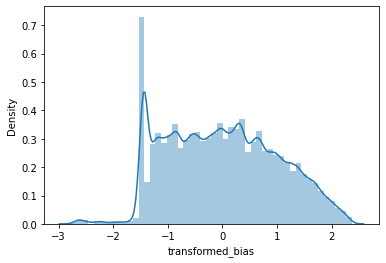

In [ ]:
sns.distplot(train_x['transformed_bias'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


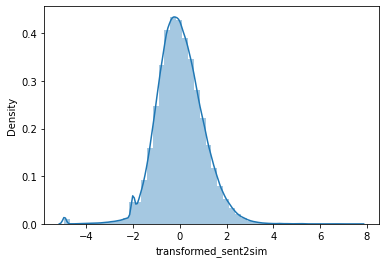

In [ ]:
sns.distplot(train_x['transformed_sent2sim'])

In [ ]:
display(train_x.head(3), val_x.head(3))

,first,SL,TF_ISF,ab2sim,SP,transformed_bias,transformed_sent2sim
0,1,0.466667,0.421750,0.544845,0.00000,0.670039,-0.872133
1,0,0.577778,0.550548,0.298872,0.07692,0.538631,0.192674
2,0,0.333333,0.244185,0.193521,0.15385,0.488308,-0.016781


,first,SL,TF_ISF,ab2sim,SP,transformed_bias,transformed_sent2sim
id,,,,,,,
366196093,1,0.054054,0.057993,0.146774,0.00000,0.360349,-1.073581
366196093,0,0.405405,0.322731,0.160651,0.11111,0.348142,-0.641370
366196093,0,0.540541,0.453334,0.081672,0.22222,0.182758,-0.922482


### 1) Decision Tree Classifier

In [ ]:
## 파라미터 튜닝 없이 돌렸을 때 
dt_model = DecisionTreeClassifier(random_state=99)
#학습
dt_model.fit(train_x, train_y)
#예측
pred = dt_model.predict(val_x)
#결과
print(accuracy_score(val_y, pred))

0.852451217900718


In [ ]:
## train set에 대해 파라미터 튜닝 
#다양한 파라미터를 주기
params = {'max_depth': [3, 5, 7, 9], 
          'max_leaf_nodes': [5, 10, 15, 20], # list(range(10, 50))
          'min_samples_leaf': [None, 1, 2]}
#5-fold cv로 그리드서치를 수행해 봄.
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=99),
                              params, verbose=1, cv=5, n_jobs=-1)
#트레인셋으로 학습, k-fold 적용
grid_search_cv.fit(train_x, train_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=99,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_

In [ ]:
print('그리드서치 결과, 가장 최적의 하이퍼 파라미터는: ',grid_search_cv.best_params_)
print('그 때의 스코어는: {0:.3f}'.format(grid_search_cv.best_score_))

그리드서치 결과, 가장 최적의 하이퍼 파라미터는:  {'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 1}
그 때의 스코어는: 0.896


In [ ]:
# 다시 전체 train set으로 학습 후, val set에 대한 예측 정확도는?
dt_model = DecisionTreeClassifier(random_state=99, max_depth= 5, max_leaf_nodes= 20, min_samples_leaf= 1) ##추가
#학습
dt_model.fit(train_x, train_y)
#예측
pred = dt_model.predict(val_x)
#결과
print(accuracy_score(val_y, pred))

0.8963132625644188


### 2) Random Forest Classifier

In [ ]:
## 파라미터 튜닝 없이 돌렸을 때 
rf_model = RandomForestClassifier(random_state=99)
#학습
rf_model.fit(train_x, train_y)
#예측
pred2 = rf_model.predict(val_x)
#결과
print(accuracy_score(val_y, pred2))

0.9048055323085055


In [ ]:
## train set에 대해 파라미터 튜닝 
#다양한 파라미터를 주기
params = {'n_estimators': [200, 500],
          'max_depth': [2, 5, 10], 
          'max_leaf_nodes': [3, 5, 10], 
          'min_samples_leaf': [None, 2, 4]}
#5-fold cv로 그리드서치를 수행해 봄.
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=99),
                              params, verbose=1, cv=5, n_jobs=-1)
#트레인셋으로 학습, k-fold 적용
grid_search_cv.fit(train_x, train_y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 132.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 204.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=99,
                                  

In [ ]:
print('그리드서치 결과, 가장 최적의 하이퍼 파라미터는: ',grid_search_cv.best_params_)
print('그 때의 스코어는: {0:.3f}'.format(grid_search_cv.best_score_))

그리드서치 결과, 가장 최적의 하이퍼 파라미터는:  {'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'n_estimators': 500}
그 때의 스코어는: 0.893


### 3) LGBM(LightGBM) with Bayesian optimization

In [1]:
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelBinarizer
import numpy as np 
import pandas as pd 
import lightgbm as lgb                       # Lightgbm 패키지
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import KFold   # K-Fold CV
from functools import partial

In [3]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"): # 여기서는 binary classification이므로 macro!
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [4]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda,
           x_data=None, y_data=None, n_splits=5, output='score'):
    
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
        model = lgb.LGBMClassifier(
            random_state=99, ##
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)
        pred = [np.argmax(line) for line in pred]
        score += multiclass_roc_auc_score(y_valid, pred, average='macro') / n_splits ##
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [2]:
# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=train_x, y_data=train_y, n_splits=5, output='score') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (16, 1024),      # n_estimators,     범위(16~1024)
        'subsample': (0.1, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0.1, 0.9),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0.1, 10),            # reg_alpha,        범위(0~10)
        'reg_lambda': (0.1, 50),           # reg_lambda,       범위(0~50)
    }, 
    random_state=2020                    # 시드 고정
)
lgbBO.maximize(init_points=5, n_iter=10) # 처음 5회 랜덤 값으로 score 계산 후 20회 최적화

In [ ]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=train_x, y_data=train_y, n_splits=5, output='model')

In [ ]:
##5 kfold 예측
preds=[]
for model in models:
    pred = model.predict_proba(val_x)
    preds.append(pred)

pred = np.mean(preds , axis=0)
pred = [np.argmax(line) for line in pred]

In [ ]:
#accuracy, confusion_maxtrix
from sklearn.metrics import accuracy_score

print(model.__class__.__name__, accuracy_score(val_y, pred))
print(); print(metrics.classification_report(val_y, pred))
print(); print(metrics.confusion_matrix(val_y, pred))

### 3) Voting Classifier

In [ ]:
#필요한 패키지 로드(모델링에 사용할 것들)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost
from sklearn.ensemble import VotingClassifier

In [ ]:
#여러가지 모델들을 만들어 보자.(파라미터 튜닝 x)
#1. randomforest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=99)
#2. extra-trees classifier
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=99)
#3. DT
dt_model = DecisionTreeClassifier(random_state=99, max_depth= 5, max_leaf_nodes= 20, min_samples_leaf= 1)
#4. xgboost classifier
xgb_clf = xgboost.XGBClassifier(random_state=99)

In [ ]:
#각 모델들을 train set으로 학습시키고, 가장 성능이 좋은 것은 무엇인지 출력
estimators = [rf_clf, et_clf, dt_model, xgb_clf]
for estimator in estimators:
    print("### Training the", estimator, "###")
    estimator.fit(train_x, train_y)

### Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=99, verbose=0,
                       warm_start=False) ###
### Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
     

In [ ]:
#validation set에 대해 예측하고, 스코어가 어떤지 출력
for estimator in estimators:
    print(estimator.__class__.__name__, ':', estimator.score(val_x, val_y))

RandomForestClassifier : 0.9048055323085055
ExtraTreesClassifier : 0.9052548121393649
DecisionTreeClassifier : 0.8963132625644188
XGBClassifier : 0.9065057481390124


In [ ]:
#각각의 estimators와 이에 이름을 붙인 'named_estimators'를 만들어 voting classifier 객체에 대입
named_estimators = [
    ("rf_clf", rf_clf), ("et_clf", et_clf),
    ("dt_model", dt_model),("xgb_clf", xgb_clf),]

#hard voting classifier
voting_clf = VotingClassifier(named_estimators, voting='hard')

#학습
voting_clf.fit(train_x, train_y)
#accuracy 스코어
voting_clf.score(val_x, val_y)

0.9057569484209136

In [ ]:
#각각의 estimators와 이에 이름을 붙인 'named_estimators'를 만들어 voting classifier 객체에 대입
named_estimators = [
    ("rf_clf", rf_clf), ("et_clf", et_clf),
    ("dt_model", dt_model),("xgb_clf", xgb_clf),]

#hard voting classifier
voting_clf = VotingClassifier(named_estimators, voting='soft')

#학습
voting_clf.fit(train_x, train_y)
#accuracy 스코어
voting_clf.score(val_x, val_y)

0.905457428533674